In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import logging
from typing import Callable
from joblib import Parallel, delayed
import time
from concurrent.futures import ThreadPoolExecutor

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
# -------------------------------
# Line Search with Armijo Condition
# -------------------------------
def line_search_original(alpha0: float,
                xk: np.ndarray,
                dx: np.ndarray,
                gk: np.ndarray,
                f: Callable[[np.ndarray], float],
                maxiters: int = 20,
                c: float = 1e-4,
                tau: float = 0.5):
    alphaj = alpha0
    Dfk = gk.dot(dx)
    fk = f(xk)
    for j in range(maxiters):
        fx = f(xk + alphaj*dx)
        flinear = fk + alphaj * c * Dfk
        if fx <= flinear:
            break
        alphaj = tau*alphaj
    return alphaj


In [4]:
# -------------------------------
# Newton's Method
# -------------------------------
def newton_original(x0: np.ndarray,
           f: Callable[[np.ndarray], float],
           grad: Callable[[np.ndarray], np.ndarray],
           hess: Callable[[np.ndarray], sp.csc_matrix],
           lsolver: Callable[[sp.csc_matrix, np.ndarray], np.ndarray],
           alpha0: Callable[[np.ndarray, np.ndarray], float],
           maxiters: int = 10,
           rtol: float = 1e-5,
           callback: Callable[[np.ndarray], None] = None):
    xk = x0
    gk = grad(x0)
    for k in range(maxiters):
        gnorm = np.linalg.norm(gk, 1)
        if gnorm < rtol:
            break
        Hk = hess(xk)
        dx = lsolver(Hk, -gk)
        alpha = line_search_original(1.0, xk, dx, gk, f)
        xk = xk + alpha*dx
        gk = grad(xk)
        if callback is not None:
            callback(xk)
    return xk


In [5]:
# -------------------------------
# Improved Line Search with Wolfe Conditions
# -------------------------------
def line_search_wolfe(
    alpha0: float,
    xk: np.ndarray,
    dx: np.ndarray,
    gk: np.ndarray,
    f: Callable[[np.ndarray], float],
    grad: Callable[[np.ndarray], np.ndarray],
    maxiters: int = 20,
    c1: float = 1e-4,
    c2: float = 0.9,
    tau: float = 0.5
) -> float:
    """
    Perform a line search to satisfy the Wolfe conditions.
    """
    alpha = alpha0
    fk = f(xk)
    Dfk = np.dot(gk, dx)

    for j in range(maxiters):
        x_new = xk + alpha * dx
        f_new = f(x_new)

        if f_new > fk + c1 * alpha * Dfk:
            break

        g_new = grad(x_new)
        if np.dot(g_new, dx) >= c2 * Dfk:
            break

        alpha *= tau
    return alpha


In [6]:
# -------------------------------
# Improved Newton's Method
# -------------------------------
def newton(
    x0: np.ndarray,
    f: Callable[[np.ndarray], float],
    grad: Callable[[np.ndarray], np.ndarray],
    hess: Callable[[np.ndarray], sp.csc_matrix],
    lsolver: Callable[[sp.csc_matrix, np.ndarray], np.ndarray],
    alpha0_func: Callable[[np.ndarray, np.ndarray], float],
    maxiters: int = 50,
    rtol: float = 1e-5,
    xtol: float = 1e-8,
    ftol: float = 1e-8,
    callback: Callable[[np.ndarray], None] = None
) -> np.ndarray:
    """
    Perform Newton's method optimization.
    """
    xk = x0.copy()
    gk = grad(xk)
    fk = f(xk)

    for k in range(maxiters):
        gnorm = np.linalg.norm(gk, 2)
        if gnorm < rtol:
            logging.info(f"Convergence achieved based on gradient norm at iteration {k}")
            break

        Hk = hess(xk)
        try:
            dx = lsolver(Hk, -gk)
        except spla.ArpackNoConvergence as e:
            logging.error(f"Linear solver failed at iteration {k}: {e}")
            break
        except Exception as e:
            logging.error(f"An error occurred in linear solver at iteration {k}: {e}")
            break

        alpha0 = alpha0_func(xk, dx)
        alpha = line_search_wolfe(alpha0, xk, dx, gk, f, grad)

        x_new = xk + alpha * dx
        g_new = grad(x_new)
        f_new = f(x_new)

        delta_x = np.linalg.norm(x_new - xk, 2)
        delta_f = abs(f_new - fk)

        logging.info(
            f"Iteration {k}: f(x) = {fk:.6f}, ||g|| = {gnorm:.6f}, ||dx|| = {np.linalg.norm(dx, 2):.6f}, "
            f"alpha = {alpha:.6f}, delta_x = {delta_x:.6f}, delta_f = {delta_f:.6f}"
        )

        if callback is not None:
            callback(x_new)

        if delta_x < xtol or delta_f < ftol:
            logging.info(f"Convergence achieved at iteration {k}")
            break

        xk = x_new
        gk = g_new
        fk = f_new

    return xk

In [7]:
# -------------------------------
# Adam-Enhanced Newton's Method
# -------------------------------
def newton_adam(
    x0: np.ndarray,
    f: Callable[[np.ndarray], float],
    grad: Callable[[np.ndarray], np.ndarray],
    hess: Callable[[np.ndarray], sp.csc_matrix],
    lsolver: Callable[[sp.csc_matrix, np.ndarray], np.ndarray],
    alpha0_func: Callable[[np.ndarray, np.ndarray], float],
    maxiters: int = 50,
    rtol: float = 1e-5,
    xtol: float = 1e-8,
    ftol: float = 1e-8,
    callback: Callable[[np.ndarray], None] = None,
    beta1: float = 0.9,
    beta2: float = 0.999,
    epsilon: float = 1e-8,
    learning_rate: float = 1e-3
) -> np.ndarray:
    """
    Perform Newton's method optimization with Adam optimizer for gradient steps.
    """
    xk = x0.copy()
    gk = grad(xk)
    fk = f(xk)
    
    m = np.zeros_like(x0)  # Initialize first moment vector
    v = np.zeros_like(x0)  # Initialize second moment vector
    t = 0  # Initialize timestep

    for k in range(maxiters):
        gnorm = np.linalg.norm(gk, 2)
        if gnorm < rtol:
            logging.info(f"Convergence achieved based on gradient norm at iteration {k}")
            break

        Hk = hess(xk)
        
        # Solve Newton direction
        try:
            dx = lsolver(Hk, -gk)
        except spla.ArpackNoConvergence as e:
            logging.error(f"Linear solver failed at iteration {k}: {e}")
            break
        except Exception as e:
            logging.error(f"An error occurred in linear solver at iteration {k}: {e}")
            break

        # Line search for step size
        alpha0 = alpha0_func(xk, dx)
        alpha = line_search_wolfe(alpha0, xk, dx, gk, f, grad)

        # Adam step for the gradient
        t += 1
        m = beta1 * m + (1 - beta1) * gk  # Update biased first moment estimate
        v = beta2 * v + (1 - beta2) * (gk ** 2)  # Update biased second moment estimate

        # Bias correction
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        # Update step using Adam
        adam_step = learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        xk = xk - adam_step

        # Update gradient and function value
        x_new = xk + alpha * dx
        g_new = grad(x_new)
        f_new = f(x_new)

        delta_x = np.linalg.norm(x_new - xk, 2)
        delta_f = abs(f_new - fk)

        logging.info(
            f"Iteration {k}: f(x) = {fk:.6f}, ||g|| = {gnorm:.6f}, ||dx|| = {np.linalg.norm(dx, 2):.6f}, "
            f"alpha = {alpha:.6f}, delta_x = {delta_x:.6f}, delta_f = {delta_f:.6f}"
        )

        if callback is not None:
            callback(x_new)

        if delta_x < xtol or delta_f < ftol:
            logging.info(f"Convergence achieved at iteration {k}")
            break

        xk = x_new
        gk = g_new
        fk = f_new

    return xk

# -------------------------------
# Parallelized Newton's Method with Adam
# -------------------------------
def newton_parallel_adam(
    x0: np.ndarray,
    f: Callable[[np.ndarray], float],
    grad: Callable[[np.ndarray], np.ndarray],
    hess: Callable[[np.ndarray], sp.csc_matrix],
    lsolver: Callable[[sp.csc_matrix, np.ndarray], np.ndarray],
    alpha0_func: Callable[[np.ndarray, np.ndarray], float],
    maxiters: int = 50,
    rtol: float = 1e-5,
    xtol: float = 1e-8,
    ftol: float = 1e-8,
    callback: Callable[[np.ndarray], None] = None,
    beta1: float = 0.9,
    beta2: float = 0.999,
    epsilon: float = 1e-8,
    learning_rate: float = 1e-3
) -> np.ndarray:
    """
    Perform Newton's method optimization with Adam optimizer and parallel computations.
    """
    xk = x0.copy()
    fk = f(xk)
    
    m = np.zeros_like(x0)
    v = np.zeros_like(x0)
    t = 0

    with ThreadPoolExecutor() as executor:
        for k in range(maxiters):
            # Submit gradient computation in parallel
            future_grad = executor.submit(grad, xk)
            gk = future_grad.result()

            gnorm = np.linalg.norm(gk, 2)
            if gnorm < rtol:
                logging.info(f"Convergence achieved based on gradient norm at iteration {k}")
                break

            # Submit Hessian computation in parallel
            future_hess = executor.submit(hess, xk)
            Hk = future_hess.result()

            # Try solving the linear system using the Hessian (parallel)
            try:
                future_solver = executor.submit(lsolver, Hk, -gk)
                dx = future_solver.result()
            except spla.ArpackNoConvergence as e:
                logging.error(f"Linear solver failed at iteration {k}: {e}")
                break
            except Exception as e:
                logging.error(f"An error occurred in linear solver at iteration {k}: {e}")
                break

            # Line search for step size
            alpha0 = alpha0_func(xk, dx)
            alpha = line_search_wolfe(alpha0, xk, dx, gk, f, grad)

            # Adam step for the gradient
            t += 1
            m = beta1 * m + (1 - beta1) * gk
            v = beta2 * v + (1 - beta2) * (gk ** 2)

            # Bias correction
            m_hat = m / (1 - beta1 ** t)
            v_hat = v / (1 - beta2 ** t)

            # Update step using Adam
            adam_step = learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
            xk = xk - adam_step

            # Update gradient and function value
            x_new = xk + alpha * dx
            g_new = grad(x_new)
            f_new = f(x_new)

            delta_x = np.linalg.norm(x_new - xk, 2)
            delta_f = abs(f_new - fk)

            logging.info(
                f"Iteration {k}: f(x) = {fk:.6f}, ||g|| = {gnorm:.6f}, ||dx|| = {np.linalg.norm(dx, 2):.6f}, "
                f"alpha = {alpha:.6f}, delta_x = {delta_x:.6f}, delta_f = {delta_f:.6f}"
            )

            if callback is not None:
                callback(x_new)

            if delta_x < xtol or delta_f < ftol:
                logging.info(f"Convergence achieved at iteration {k}")
                break

            xk = x_new
            fk = f_new

    return xk

In [8]:

# -------------------------------
# Parallelized Improved Newton's Method
# -------------------------------
def newton_parallel(
    x0: np.ndarray,
    f: Callable[[np.ndarray], float],
    grad: Callable[[np.ndarray], np.ndarray],
    hess: Callable[[np.ndarray], sp.csc_matrix],
    lsolver: Callable[[sp.csc_matrix, np.ndarray], np.ndarray],
    alpha0_func: Callable[[np.ndarray, np.ndarray], float],
    maxiters: int = 50,
    rtol: float = 1e-5,
    xtol: float = 1e-8,
    ftol: float = 1e-8,
    callback: Callable[[np.ndarray], None] = None
) -> np.ndarray:
    """
    Perform Newton's method optimization with parallelized gradient and Hessian solve.
    """
    xk = x0.copy()
    fk = f(xk)

    with ThreadPoolExecutor() as executor:
        for k in range(maxiters):
            # Submit gradient computation in parallel
            future_grad = executor.submit(grad, xk)
            gk = future_grad.result()  # Fetch result when done

            gnorm = np.linalg.norm(gk, 2)
            if gnorm < rtol:
                logging.info(f"Convergence achieved based on gradient norm at iteration {k}")
                break

            # Submit Hessian computation in parallel
            future_hess = executor.submit(hess, xk)
            Hk = future_hess.result()  # Fetch result when done

            # Try solving the linear system using the Hessian (parallel)
            try:
                future_solver = executor.submit(lsolver, Hk, -gk)
                dx = future_solver.result()
            except spla.ArpackNoConvergence as e:
                logging.error(f"Linear solver failed at iteration {k}: {e}")
                break
            except Exception as e:
                logging.error(f"An error occurred in linear solver at iteration {k}: {e}")
                break

            # Line search for step size
            alpha0 = alpha0_func(xk, dx)
            alpha = line_search_wolfe(alpha0, xk, dx, gk, f, grad)

            x_new = xk + alpha * dx
            f_new = f(x_new)

            delta_x = np.linalg.norm(x_new - xk, 2)
            delta_f = abs(f_new - fk)

            logging.info(
                f"Iteration {k}: f(x) = {fk:.6f}, ||g|| = {gnorm:.6f}, ||dx|| = {np.linalg.norm(dx, 2):.6f}, "
                f"alpha = {alpha:.6f}, delta_x = {delta_x:.6f}, delta_f = {delta_f:.6f}"
            )

            if callback is not None:
                callback(x_new)

            if delta_x < xtol or delta_f < ftol:
                logging.info(f"Convergence achieved at iteration {k}")
                break

            xk = x_new
            fk = f_new

    return xk


In [9]:
# -------------------------------
# Example Linear Solver with Preconditioning
# -------------------------------
def preconditioned_cg_solver(H: sp.csc_matrix, b: np.ndarray) -> np.ndarray:
    try:
        ilu = spla.spilu(H)
        Mx = lambda x: ilu.solve(x)
        M = spla.LinearOperator(H.shape, Mx)
    except Exception as e:
        logging.warning(f"ILU preconditioner failed: {e}. Using no preconditioner.")
        M = None

    x, info = spla.cg(H, b, maxiter=1000, M=M)
    if info != 0:
        raise spla.ArpackNoConvergence(f"Preconditioned CG did not converge, info={info}")
    return x


In [10]:
# -------------------------------
# Define the Initial Step Size Function (Constant)
# -------------------------------
def constant_alpha0(xk: np.ndarray, dx: np.ndarray) -> float:
    return 1.0


In [11]:
# -------------------------------
# Quadratic Optimization Problem Generator
# -------------------------------
def generate_quadratic_problem(n: int, density: float = 0.01) -> Callable:
    A = sp.random(n, n, density=density, format='csc', data_rvs=np.random.randn)
    A = A + A.T + n * sp.eye(n)

    b = np.random.randn(n)
    x0 = np.random.randn(n)

    def f(x: np.ndarray) -> float:
        return 0.5 * x.dot(A.dot(x)) - b.dot(x)

    def grad(x: np.ndarray) -> np.ndarray:
        return A.dot(x) - b

    def hess(x: np.ndarray) -> sp.csc_matrix:
        return A

    return f, grad, hess, x0

# -------------------------------
# Quadratic Optimization Problem Generator with Contact and Friction
# -------------------------------
def generate_contact_friction_problem(n: int, density: float = 0.01, 
                                     num_contacts: int = 1, 
                                     friction_coeff: float = 0.5, 
                                     penalty_contact: float = 1e5,
                                     penalty_friction: float = 1e3) -> Callable:
    """
    Generate a quadratic optimization problem with contact and friction penalties.

    Parameters:
    - n: Number of variables (positions and forces)
    - density: Sparsity density of the A matrix
    - num_contacts: Number of contact constraints
    - friction_coeff: Friction coefficient mu
    - penalty_contact: Penalty coefficient for contact violation (x_i < 0)
    - penalty_friction: Penalty coefficient for friction violation

    Returns:
    - f: Objective function
    - grad: Gradient of f
    - hess: Hessian of f
    - x0: Initial guess
    """
    # Generate a random sparse positive definite matrix A
    A = sp.random(n, n, density=density, format='csc', data_rvs=np.random.randn)
    A = A + A.T + n * sp.eye(n)  # Ensure positive definiteness

    b = np.random.randn(n)
    x0 = np.random.randn(n)

    # Define contact indices randomly
    contact_indices = np.random.choice(n, size=num_contacts, replace=False)

    # For simplicity, assume that for each contact index i,
    # x_i represents the position and x_j represents the normal force
    # Here, we'll pair contact indices with their corresponding normal forces
    # For example, if i is a contact index, j = i + n//2 (assuming n is even)
    # Ensure that j does not exceed bounds
    if n < 2 * num_contacts:
        raise ValueError("Number of variables n must be at least twice the number of contacts.")

    friction_pairs = []
    for idx in contact_indices:
        j = idx + num_contacts  # Simple pairing strategy
        if j >= n:
            j = idx - num_contacts  # Adjust if out of bounds
            if j < 0:
                raise ValueError("Cannot create friction pair for index {}".format(idx))
        friction_pairs.append((idx, j))

    def f_obj(x: np.ndarray) -> float:
        # Original quadratic objective
        obj = 0.5 * x.dot(A.dot(x)) - b.dot(x)

        # Contact penalty: x_i < 0
        contact_penalty = penalty_contact * np.sum(np.minimum(0, x[contact_indices])**2)

        # Friction penalty: |f_t_i| > mu * f_n_i
        # f_t_i = x_i (assuming i indexes tangential forces)
        # f_n_i = x_j (assuming j indexes normal forces)
        friction_penalty = 0.0
        for (i, j) in friction_pairs:
            ft = x[i]
            fn = x[j]
            # Penalize (|ft| - mu * fn)^2 if |ft| > mu * fn
            friction_penalty += penalty_friction * max(0, abs(ft) - friction_coeff * fn)**2
        obj += contact_penalty + friction_penalty
        return obj
    def grad_obj(x: np.ndarray) -> np.ndarray:
        grad = A.dot(x) - b

        # Contact penalty gradient
        contact_grad = penalty_contact * 2 * np.minimum(0, x[contact_indices])
        grad[contact_indices] += contact_grad

        # Friction penalty gradient
        for (i, j) in friction_pairs:
            ft = x[i]
            fn = x[j]
            if abs(ft) > friction_coeff * fn:
                sign_ft = np.sign(ft) if ft != 0 else 0
                grad[i] += penalty_friction * 2 * (abs(ft) - friction_coeff * fn) * sign_ft
                grad[j] += penalty_friction * (-2 * friction_coeff) * (abs(ft) - friction_coeff * fn)

        return grad
    def hess_obj(x: np.ndarray) -> sp.csc_matrix:
        # Original Hessian
        H = A.copy()

        # Contact penalty Hessian: derivative of contact_grad
        # For x_i < 0, d^2 penalty_contact * (x_i)^2 / dx_i^2 = 2 * penalty_contact
        # Otherwise, derivative is 0
        H = H.tolil()
        for i in contact_indices:
            if x0[i] < 0:
                H[i, i] += 2 * penalty_contact

        # Friction penalty Hessian
        for (i, j) in friction_pairs:
            ft = x0[i]
            fn = x0[j]
            if abs(ft) > friction_coeff * fn:
                # Second derivatives
                # d^2/dx_i^2: 2 * penalty_friction
                H[i, i] += 2 * penalty_friction
                # d^2/dx_j^2: 0
                # d^2/dx_i dx_j: -2 * penalty_friction * friction_coeff * sign(ft)
                H[i, j] += -2 * penalty_friction * friction_coeff * np.sign(ft)
                H[j, i] += -2 * penalty_friction * friction_coeff * np.sign(ft)

        H = H.tocsc()
        return H

    return f_obj, grad_obj, hess_obj, x0


In [12]:
# -------------------------------
# Performance Measurement Decorator
# -------------------------------
def measure_performance(func: Callable) -> Callable:
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        mem_usage, result = memory_usage((func, args, kwargs), retval=True, max_iterations=1, interval=0.1)
        end_time = time.perf_counter()
        elapsed_time = end_time - start_time
        peak_mem = max(mem_usage) - min(mem_usage)
        return result, elapsed_time, peak_mem
    return wrapper


In [13]:
# -------------------------------
# Parallel Performance Testing Function
# -------------------------------
@measure_performance
def run_performance_test(n: int, density: float = 0.01) -> dict:
    f, grad, hess, x0 = generate_quadratic_problem(n, density)

    try:
        xmin = newton(
            x0=x0,
            f=f,
            grad=grad,
            hess=hess,
            lsolver=preconditioned_cg_solver,
            alpha0_func=constant_alpha0,
            maxiters=100,
            rtol=1e-5,
            xtol=1e-8,
            ftol=1e-8,
            callback=None
        )
    except spla.ArpackNoConvergence as e:
        logging.error(f"Newton's method failed for n={n}: {e}")
        xmin = None

    return {'n': n, 'xmin': xmin}

@measure_performance
def run_performance_test_original(n: int, density: float = 0.01) -> dict:
    f, grad, hess, x0 = generate_quadratic_problem(n, density)

    try:
        xmin = newton_original(
            x0=x0,
            f=f,
            grad=grad,
            hess=hess,
            lsolver=preconditioned_cg_solver,
            alpha0=constant_alpha0,
            maxiters=100,
            rtol=1e-5,
            callback=None
        )
    except spla.ArpackNoConvergence as e:
        logging.error(f"Original Newton's method failed for n={n}: {e}")
        xmin = None

    return {'n': n, 'xmin': xmin}

@measure_performance
def run_performance_tests_parallel(n: int, density: float = 0.01) -> dict:
    f, grad, hess, x0 = generate_quadratic_problem(n, density)

    try:
        xmin = newton_parallel(
            x0=x0,
            f=f,
            grad=grad,
            hess=hess,
            lsolver=preconditioned_cg_solver,
            alpha0_func=constant_alpha0,
            maxiters=100,
            rtol=1e-5,
            xtol=1e-8,
            ftol=1e-8,
            callback=None
        )
    except spla.ArpackNoConvergence as e:
        logging.error(f"Parallel Newton's method failed for n={n}: {e}")
        xmin = None

    return {'n': n, 'xmin': xmin}

@measure_performance
def run_performance_test_adam(n: int, density: float = 0.01) -> dict:
    f, grad, hess, x0 = generate_quadratic_problem(n, density)

    try:
        xmin = newton_adam(
            x0=x0,
            f=f,
            grad=grad,
            hess=hess,
            lsolver=preconditioned_cg_solver,
            alpha0_func=constant_alpha0,
            maxiters=100,
            rtol=1e-5,
            xtol=1e-8,
            ftol=1e-8,
            callback=None
        )
    except spla.ArpackNoConvergence as e:
        logging.error(f"Newton's method with Adam failed for n={n}: {e}")
        xmin = None

    return {'n': n, 'xmin': xmin}


@measure_performance
def run_performance_test_adam_parallel(n: int, density: float = 0.01) -> dict:
    f, grad, hess, x0 = generate_quadratic_problem(n, density)

    try:
        xmin = newton_parallel_adam(
            x0=x0,
            f=f,
            grad=grad,
            hess=hess,
            lsolver=preconditioned_cg_solver,
            alpha0_func=constant_alpha0,
            maxiters=100,
            rtol=1e-5,
            xtol=1e-8,
            ftol=1e-8,
            callback=None
        )
    except spla.ArpackNoConvergence as e:
        logging.error(f"Parallel Newton's method with Adam failed for n={n}: {e}")
        xmin = None

    return {'n': n, 'xmin': xmin}


def run_parallel_performance_tests_with_original(problem_sizes):
    # Run both original and improved in parallel
    original_results = Parallel(n_jobs=-1, backend="threading")(
        delayed(run_performance_test_original)(n) for n in problem_sizes
    )
    improved_results = Parallel(n_jobs=-1, backend="threading")(
        delayed(run_performance_test)(n) for n in problem_sizes
    )

    # Run parallel tests and collect results
    parallel_results = Parallel(n_jobs=-1, backend="threading")(
        delayed(run_performance_tests_parallel)(n) for n in problem_sizes
    )

    # Run Adam tests and collect results
    adam_results = Parallel(n_jobs=-1, backend="threading")(
        delayed(run_performance_test_adam)(n) for n in problem_sizes
    )

    # Run Adam tests and collect results
    adam_parallel_results = Parallel(n_jobs=-1, backend="threading")(
        delayed(run_performance_test_adam_parallel)(n) for n in problem_sizes
    )

    # Extract elapsed times
    original_times = [result[1] for result in original_results]
    improved_times = [result[1] for result in improved_results]
    parallel_times = [result[1] for result in parallel_results]
    adam_times = [result[1] for result in adam_results]
    adam_parallel_times = [result[1] for result in adam_parallel_results]

    # Extract peak memory usages
    original_memories = [result[2] for result in original_results]
    improved_memories = [result[2] for result in improved_results]
    parallel_memories = [result[2] for result in parallel_results]
    adam_memories = [result[2] for result in adam_results]
    adam_parallel_memories = [result[2] for result in adam_parallel_results]


    return original_times, improved_times, original_memories, improved_memories, parallel_times, parallel_memories, adam_times, adam_memories, adam_parallel_times, adam_parallel_memories



In [14]:
# -------------------------------
# Parallel Performance Testing Function
# -------------------------------
@measure_performance
def run_performance_test_contact_friction(n: int, density: float = 0.01) -> dict:
    f, grad, hess, x0 = generate_contact_friction_problem(n, density)

    try:
        xmin = newton(
            x0=x0,
            f=f,
            grad=grad,
            hess=hess,
            lsolver=preconditioned_cg_solver,
            alpha0_func=constant_alpha0,
            maxiters=100,
            rtol=1e-5,
            xtol=1e-8,
            ftol=1e-8,
            callback=None
        )
    except spla.ArpackNoConvergence as e:
        logging.error(f"Newton's method failed for n={n}: {e}")
        xmin = None

    return {'n': n, 'xmin': xmin}

@measure_performance
def run_performance_test_contact_friction_original(n: int, density: float = 0.01) -> dict:
    f, grad, hess, x0 = generate_contact_friction_problem(n, density)

    try:
        xmin = newton_original(
            x0=x0,
            f=f,
            grad=grad,
            hess=hess,
            lsolver=preconditioned_cg_solver,
            alpha0=constant_alpha0,
            maxiters=100,
            rtol=1e-5,
            callback=None
        )
    except spla.ArpackNoConvergence as e:
        logging.error(f"Original Newton's method failed for n={n}: {e}")
        xmin = None

    return {'n': n, 'xmin': xmin}

@measure_performance
def run_performance_tests_parallel_contact_friction(n: int, density: float = 0.01) -> dict:
    f, grad, hess, x0 = generate_contact_friction_problem(n, density)

    try:
        xmin = newton_parallel(
            x0=x0,
            f=f,
            grad=grad,
            hess=hess,
            lsolver=preconditioned_cg_solver,
            alpha0_func=constant_alpha0,
            maxiters=100,
            rtol=1e-5,
            xtol=1e-8,
            ftol=1e-8,
            callback=None
        )
    except spla.ArpackNoConvergence as e:
        logging.error(f"Parallel Newton's method failed for n={n}: {e}")
        xmin = None

    return {'n': n, 'xmin': xmin}

@measure_performance
def run_performance_test_adam_contact_friction(n: int, density: float = 0.01) -> dict:
    f, grad, hess, x0 = generate_contact_friction_problem(n, density)

    try:
        xmin = newton_adam(
            x0=x0,
            f=f,
            grad=grad,
            hess=hess,
            lsolver=preconditioned_cg_solver,
            alpha0_func=constant_alpha0,
            maxiters=100,
            rtol=1e-5,
            xtol=1e-8,
            ftol=1e-8,
            callback=None
        )
    except spla.ArpackNoConvergence as e:
        logging.error(f"Newton's method with Adam failed for n={n}: {e}")
        xmin = None

    return {'n': n, 'xmin': xmin}

@measure_performance
def run_performance_test_adam_parallel_contact_friction(n: int, density: float = 0.01) -> dict:
    f, grad, hess, x0 = generate_contact_friction_problem(n, density)

    try:
        xmin = newton_parallel_adam(
            x0=x0,
            f=f,
            grad=grad,
            hess=hess,
            lsolver=preconditioned_cg_solver,
            alpha0_func=constant_alpha0,
            maxiters=100,
            rtol=1e-5,
            xtol=1e-8,
            ftol=1e-8,
            callback=None
        )
    except spla.ArpackNoConvergence as e:
        logging.error(f"Parallel Newton's method with Adam failed for n={n}: {e}")
        xmin = None

    return {'n': n, 'xmin': xmin}

@measure_performance
def run_performance_test_adam_parallel_contact_friction(n: int, density: float = 0.01) -> dict:
    f, grad, hess, x0 = generate_contact_friction_problem(n, density)

    try:
        xmin = newton_parallel_adam(
            x0=x0,
            f=f,
            grad=grad,
            hess=hess,
            lsolver=preconditioned_cg_solver,
            alpha0_func=constant_alpha0,
            maxiters=100,
            rtol=1e-5,
            xtol=1e-8,
            ftol=1e-8,
            callback=None
        )
    except spla.ArpackNoConvergence as e:
        logging.error(f"Parallel Newton's method with Adam failed for n={n}: {e}")
        xmin = None

    return {'n': n, 'xmin': xmin}

def run_parallel_performance_tests_with_original_contact_friction(problem_sizes):
    # Run both original and improved in parallel
    original_results = Parallel(n_jobs=-1, backend="threading")(
        delayed(run_performance_test_contact_friction_original)(n) for n in problem_sizes
    )
    improved_results = Parallel(n_jobs=-1, backend="threading")(
        delayed(run_performance_test_contact_friction)(n) for n in problem_sizes
    )

    # Run parallel tests and collect results
    parallel_results = Parallel(n_jobs=-1, backend="threading")(
        delayed(run_performance_tests_parallel_contact_friction)(n) for n in problem_sizes
    )

    # Run Adam tests and collect results
    adam_results = Parallel(n_jobs=-1, backend="threading")(
        delayed(run_performance_test_adam_contact_friction)(n) for n in problem_sizes
    )

    # Run Adam tests and collect results
    adam_parallel_results = Parallel(n_jobs=-1, backend="threading")(
        delayed(run_performance_test_adam_parallel_contact_friction)(n) for n in problem_sizes
    )

    # Extract elapsed times
    original_times = [result[1] for result in original_results]
    improved_times = [result[1] for result in improved_results]
    parallel_times = [result[1] for result in parallel_results]
    adam_times = [result[1] for result in adam_results]
    adam_parallel_times = [result[1] for result in adam_parallel_results]

    # Extract peak memory usages
    original_memories = [result[2] for result in original_results]
    improved_memories = [result[2] for result in improved_results]
    parallel_memories = [result[2] for result in parallel_results]
    adam_memories = [result[2] for result in adam_results]
    adam_parallel_memories = [result[2] for result in adam_parallel_results]

    return original_times, improved_times, original_memories, improved_memories, parallel_times, parallel_memories, adam_times, adam_memories, adam_parallel_times, adam_parallel_memories


In [15]:
# -------------------------------
# Performance Measurement and Plotting
# -------------------------------
def main():
    problem_sizes = [10, 100, 1000, 2000]

    logging.info(f"Running performance tests in parallel for sizes {problem_sizes}")

    # Run tests in parallel
    original_times, improved_times, original_memories, improved_memories, parallel_times, parallel_memories, adam_times, adam_memories, adam_parallel_times, adam_parallel_memories = run_parallel_performance_tests_with_original(problem_sizes)
    original_times_contact_friction, improved_times_contact_friction, original_memories_contact_friction, improved_memories_contact_friction, parallel_times_contact_friction, parallel_memories_contact_friction, adam_times_contact_friction, adam_memories_contact_friction, adam_parallel_times_contact_friction, adam_parallel_memories_contact_friction = run_parallel_performance_tests_with_original_contact_friction(problem_sizes)

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(problem_sizes, original_times, 'o-', label='Original Newton Method')
    plt.plot(problem_sizes, improved_times, 'o-', label='Improved Newton Method')
    plt.plot(problem_sizes, parallel_times, 'o-', label='Parallel Newton Method')
    plt.plot(problem_sizes, adam_times, 'o-', label='Newton with Adam Method')
    plt.plot(problem_sizes, adam_parallel_times, 'o-', label='Parallel Newton with Adam Method')
    plt.plot(problem_sizes, original_times_contact_friction, 'o-', label='Original Newton with Contact and Friction')
    plt.plot(problem_sizes, improved_times_contact_friction, 'o-', label='Improved Newton with Contact and Friction')
    plt.plot(problem_sizes, parallel_times_contact_friction, 'o-', label='Parallel Newton with Contact and Friction')
    plt.plot(problem_sizes, adam_times_contact_friction, 'o-', label='Newton with Adam with Contact and Friction')
    plt.plot(problem_sizes, adam_parallel_times_contact_friction, 'o-', label='Parallel Newton with Adam with Contact and Friction')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Problem Size')
    plt.ylabel('Time (s)')
    plt.legend()
    plt.title('Performance of Newton Methods')

    plt.subplot(1, 2, 2)
    plt.plot(problem_sizes, original_memories, 'o-', label='Original Newton')
    plt.plot(problem_sizes, improved_memories, 'o-', label='Improved Newton')
    plt.plot(problem_sizes, parallel_memories, 'o-', label='Parallel Newton')
    plt.plot(problem_sizes, adam_memories, 'o-', label='Newton with Adam')
    plt.plot(problem_sizes, adam_parallel_memories, 'o-', label='Parallel Newton with Adam')
    plt.plot(problem_sizes, original_memories_contact_friction, 'o-', label='Original Newton with Contact and Friction')
    plt.plot(problem_sizes, improved_memories_contact_friction, 'o-', label='Improved Newton with Contact and Friction')
    plt.plot(problem_sizes, parallel_memories_contact_friction, 'o-', label='Parallel Newton with Contact and Friction')
    plt.plot(problem_sizes, adam_memories_contact_friction, 'o-', label='Newton with Adam with Contact and Friction')
    plt.plot(problem_sizes, adam_parallel_memories_contact_friction, 'o-', label='Parallel Newton with Adam with Contact and Friction')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Problem Size')
    plt.ylabel('Memory Usage (MB)')
    plt.legend()
    plt.title('Memory Usage of Newton Methods')

    plt.tight_layout()
    plt.show()


2024-09-16 16:19:38,714 - INFO - Running performance tests in parallel for sizes [10, 100, 1000, 2000]
2024-09-16 16:19:45,549 - INFO - Iteration 0: f(x) = 4717.651963, ||g|| = 970.392688, ||dx|| = 9.725242, alpha = 1.000000, delta_x = 9.725242, delta_f = 4718.180104
2024-09-16 16:19:45,549 - INFO - Convergence achieved based on gradient norm at iteration 1
2024-09-16 16:19:46,140 - INFO - Iteration 0: f(x) = 72.784357, ||g|| = 37.696572, ||dx|| = 3.882382, alpha = 1.000000, delta_x = 3.882382, delta_f = 72.968849
2024-09-16 16:19:46,140 - INFO - Convergence achieved based on gradient norm at iteration 1
2024-09-16 16:19:46,140 - INFO - Iteration 0: f(x) = 506671.162569, ||g|| = 31832.434245, ||dx|| = 31.833985, alpha = 1.000000, delta_x = 31.833985, delta_f = 506671.631487
2024-09-16 16:19:46,303 - INFO - Iteration 1: f(x) = -0.468918, ||g|| = 0.000230, ||dx|| = 0.000000, alpha = 1.000000, delta_x = 0.000000, delta_f = 0.000000
2024-09-16 16:19:46,303 - INFO - Convergence achieved at 

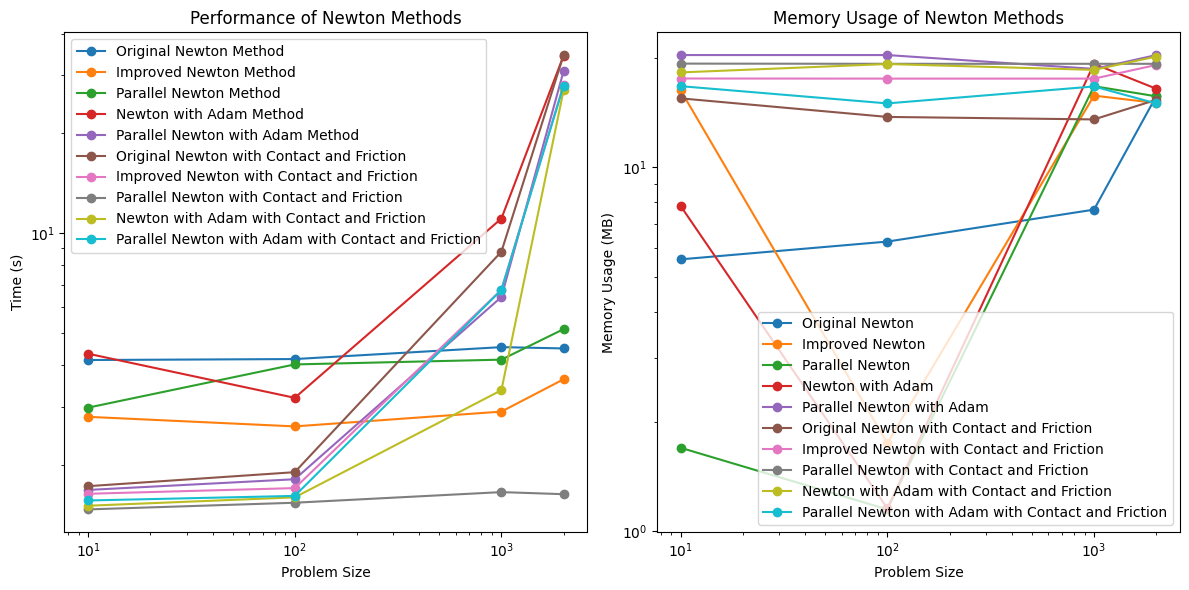

In [16]:
# Run the performance tests and plot
main()